# Example of segmentation for a simple sinosoidal channel structure

### Import libraries and settings

In [145]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
%matplotlib inline
import sys
sys.path.append("../../")
from bayseg import BaySeg
import sklearn
import sys
sys.path.append("../")
import bayseg

### Generate latent field

First, we create a simple latent field, here a channel sinosoidal channel structure:

In [92]:
xvals = np.arange(0,1,0.025)
yvals = np.arange(0,1,0.025)
X,Y = np.meshgrid(xvals, yvals)
field = np.ones_like(X)

Text(0,0.5,'Y')

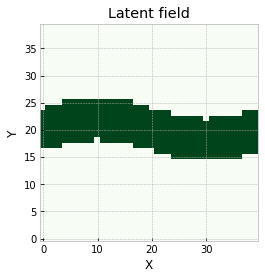

In [93]:
latent_field = field * (Y > (0.4+np.sin(xvals*2*np.pi)*0.05)) * (Y < (0.6+np.sin(xvals*2*np.pi)*0.05))
plt.imshow(latent_field, origin='lower left', cmap='Greens')
plt.title("Latent field")
plt.xlabel("X")
plt.ylabel("Y")

### Generate features

Next, we generate the feature fields from this latent field. Experiment with settings for means and covariance matrices to obtain different feature sets (easy and difficult to separate):

In [235]:
c1 = stats.multivariate_normal([6,9], [[0.5625, 0.225],[0.225, 0.675]])
# c2 = stats.multivariate_normal([4,12], [[1.125, 0.225],[0.225, 0.675]])
# FW: try different means for a more difficult estimation:
c2 = stats.multivariate_normal([5,10], [[1.125, 0.225],[0.225, 0.675]])


# c3 = stats.multivariate_normal([9,14], [[0.5625, 0.0225],[0.0225, 0.675]])

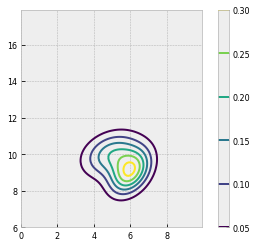

In [236]:
x1, y1 = np.mgrid[-0:10:.1, 6:18:.1]
pos = np.empty(x1.shape + (2,))
pos[:, :, 0] = x1; pos[:, :, 1] = y1
plt.contour(x1, y1, c1.pdf(pos) + c2.pdf(pos))#, levels=np.arange(0,3,0.025)) # + c3.pdf(pos))
ax = plt.gca()
ax.set_aspect("equal")
plt.colorbar()

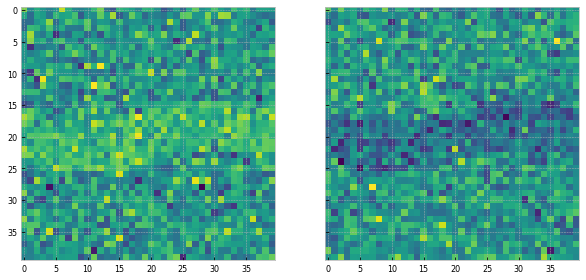

In [237]:
fig, ax = plt.subplots(ncols=2, figsize=(10,5), sharex=True, sharey=True)
f1_0 = c1.rvs(size=(latent_field.size))[:,0].reshape(latent_field.shape[0],latent_field.shape[1])
f1_1 = c1.rvs(size=(latent_field.size))[:,1].reshape(latent_field.shape[0],latent_field.shape[1])
f2_0 = c2.rvs(size=(latent_field.size))[:,0].reshape(latent_field.shape[0],latent_field.shape[1])
f2_1 = c2.rvs(size=(latent_field.size))[:,1].reshape(latent_field.shape[0],latent_field.shape[1])



feature_1 = np.zeros_like(latent_field)
feature_1 = np.where(latent_field == 0, feature_1, f1_0)
feature_1 = np.where(latent_field == 1, feature_1, f2_0)

feature_2 = np.zeros_like(latent_field)
feature_2 = np.where(latent_field == 0, feature_2, f1_1)
feature_2 = np.where(latent_field == 1, feature_2, f2_1)

ax[0].imshow(feature_1)
ax[1].imshow(feature_2)

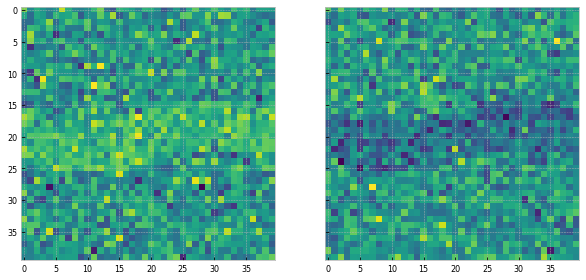

In [238]:
features = np.zeros((latent_field.shape[0], latent_field.shape[1], 2))
features[:,:,0] = np.where(latent_field == 0, features[:,:,0], f1_0)
features[:,:,0] = np.where(latent_field == 1, features[:,:,0], f2_0)
features[:,:,1] = np.where(latent_field == 0, features[:,:,1], f1_1)
features[:,:,1] = np.where(latent_field == 1, features[:,:,1], f2_1)

fig, ax = plt.subplots(ncols=2, figsize=(10,5), sharex=True, sharey=True)
ax[0].imshow(features[:,:,0])
ax[1].imshow(features[:,:,1])

In [239]:
clf = bayseg.BaySeg(features, 2, beta_init=1)

In [240]:
n_iter = 1000
clf.fit(n_iter, beta_jump_length=0.1)

100%|██████████| 1000/1000 [00:39<00:00, 15.52it/s]


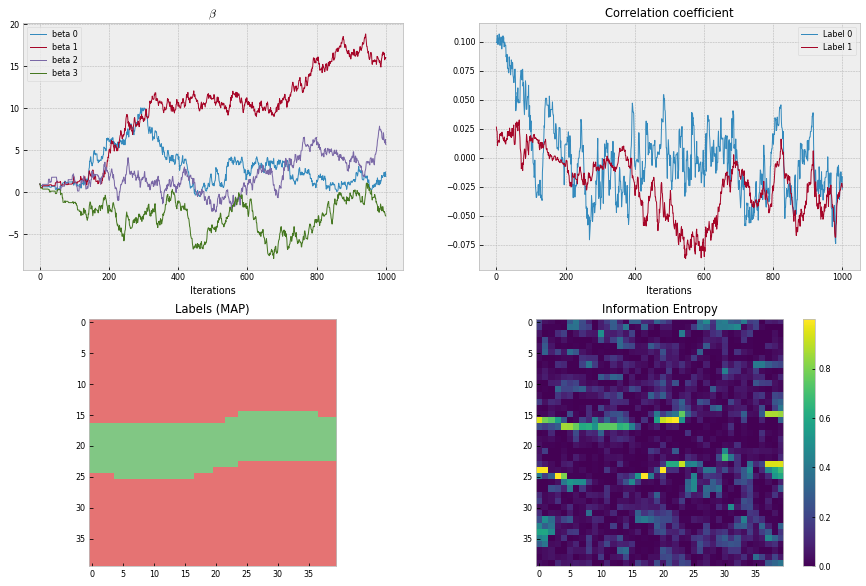

In [241]:
clf.diagnostics_plot()

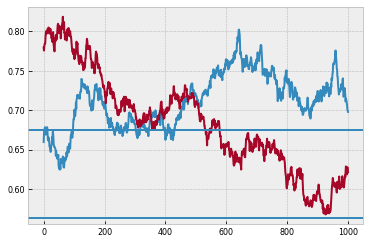

In [257]:
plt.plot(clf.covs[:,1,0,0])
plt.plot(clf.covs[:,1,1,1])
plt.axhline(c1.cov[0,0])
plt.axhline(c1.cov[1,1])

### Compare to kmeans and GMM in feature space

As a next step, let's compare the results from the HMRF-GMM model to kmeans and GMM in feature space only:

In [243]:
gmm = sklearn.mixture.GaussianMixture(n_components=2)

In [244]:
data = np.vstack([feature_1.ravel(), feature_2.ravel()])

In [245]:
gmm.fit(data.T)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=2, n_init=1, precisions_init=None,
        random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

In [246]:
gmm.covariances_[0].shape

(2, 2)

In [247]:
gmm.covariances_

array([[[0.65952763, 0.01887658],
        [0.01887658, 0.779437  ]],

       [[0.78180872, 0.0686814 ],
        [0.0686814 , 0.61176399]]])

In [248]:
c1.cov, c2.cov

(array([[0.5625, 0.225 ],
        [0.225 , 0.675 ]]), array([[1.125, 0.225],
        [0.225, 0.675]]))

In [249]:
pred = gmm.predict(data.T)

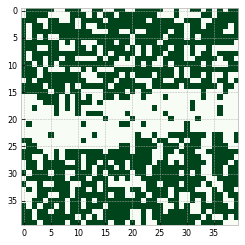

In [250]:
plt.imshow(pred.reshape((40,40)), cmap="Greens")

In [251]:
pred_prob = gmm.predict_proba(data.T)

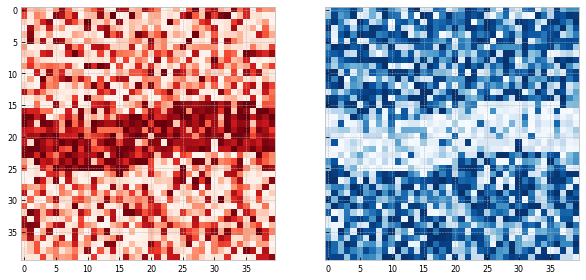

In [252]:
fig, ax = plt.subplots(ncols=2, figsize=(10,5), sharex=True, sharey=True)
ax[0].imshow(pred_prob[:,0].reshape((40,40)), cmap="Reds")
# plt.colorbar()
ax[1].imshow(pred_prob[:,1].reshape((40,40)), cmap="Blues")
# plt.colorbar()


In [253]:
kmeans = sklearn.cluster.KMeans(n_clusters=2)

In [254]:
kmeans.fit(data.T)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [255]:
pred = kmeans.predict(data.T)

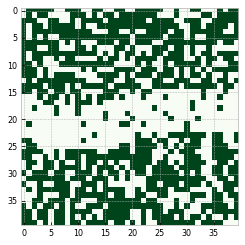

In [256]:
plt.imshow(pred.reshape(40,40), cmap='Greens')